# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [56]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file   = './datas/train.p'
validation_file = './datas/valid.p'
testing_file    = './datas/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# scale input to 0,1
X_train = X_train.astype(np.float32) / 255.0
X_valid = X_valid.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

Load some required modules

In [2]:
import tensorflow as tf
import numpy as np
import os
import collections
import sys
import time

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

def isSubset(a, b):
    '''
    test if b is subset of a
    '''
    b = np.unique(b)
    c = np.intersect1d(a,b)
    return c.size == b.size

# check if any label in valid not in y_train
print('validation-label is subset of train-labels: {}'.format(isSubset(y_train, y_valid)))
print('test-label is subset of train-labels: {}\n'.format(isSubset(y_test, y_valid)))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

def labelToIndices(y):
    '''
    we build a map label -> list of indices that contains it
    '''
    label_to_idx = {}
    for i in range(43):
        label_to_idx[i] = np.where(y == i)[0]
    return label_to_idx

# build the maps
train_maps = labelToIndices(y_train)
valid_maps = labelToIndices(y_valid)
test_maps  = labelToIndices(y_test)

validation-label is subset of train-labels: True
test-label is subset of train-labels: True

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def showImg(img, label, ax = None):
    '''
    this function show image & label
    '''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # draw image
    ax.set_title('Label: {}'.format(label), fontsize=8)
    ax.imshow(img)
    
def gridView(imgs, labels, ncols = 3, figsize = (8, 15)):
    '''
    this function draw a grid of images & labels
    '''
    nrows = (len(imgs) + ncols - 1) // ncols
    fig, axes = plt.subplots(figsize= figsize, nrows=nrows, ncols=ncols, sharey=True, sharex=True)
        
    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')
        if i < len(imgs):
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

            showImg(imgs[i], labels[i], ax = ax)

def visualizeTrafficSign(X, label_to_idx):
    '''
    this function draws one sign per label for all labels
    '''
    imgs = []
    labels = []
    for i in range(43):
        indices = label_to_idx.get(i, [])
        count = len(indices)
        if count > 0:
            imgs.append(X[indices[np.random.randint(count)]])
            labels.append('{}:{}'.format(i, count))
    
    gridView(imgs, labels, ncols=5)
        

def histogram(y, title):
    bins = np.arange(np.max(y) + 1) - 0.5
    hist, bins = np.histogram(y, bins=bins)
    
    plt.figure()
    plt.hist(y, bins=bins)
    plt.title(title)
    plt.text(45, 0.5*np.max(hist), 'min-count = {}\nmax-count = {}'.format(np.min(hist),
                                                                           np.max(hist)))
    plt.show()

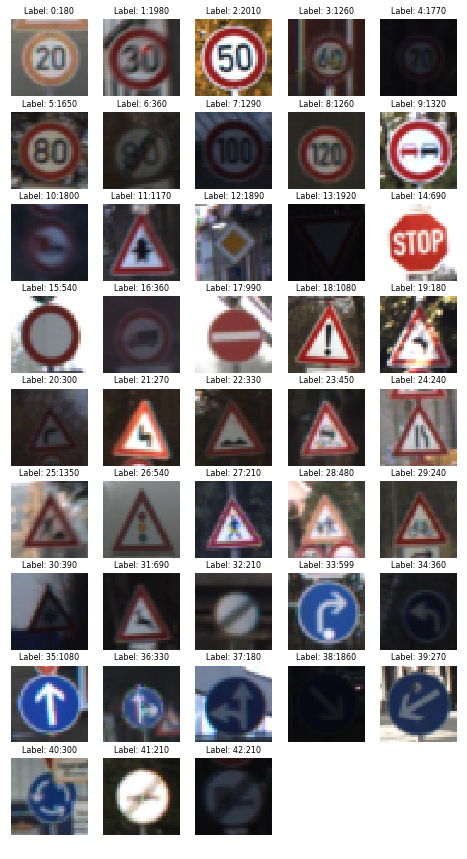

In [57]:
# visualize some traffic-sign & label
visualizeTrafficSign(X_train, train_maps)

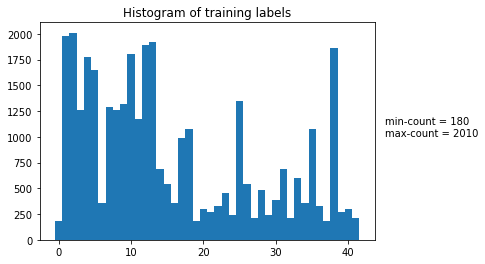

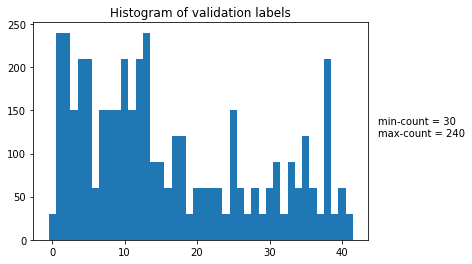

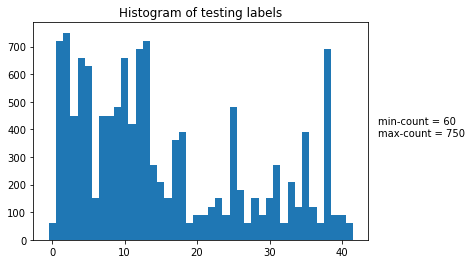

In [58]:
# visualize histogram of labels
histogram(y_train, 'Histogram of training labels')
histogram(y_valid, 'Histogram of validation labels')
histogram(y_test, 'Histogram of testing labels')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

#### Data augmentation
Examine the dataset we notice that
* some labels have a lot of training e.g label 2 (speed-limit-50) with 2010 samples
* some labels have few samples e.g label 0 (speed-limit-20) with only 180 samples.

In the baseline model, it builds a jttered dataset by doing
* translate in position: [-2, 2] pixels
* scale [.9, 1.1] ratio
* rotation [-15, +15]

Here we will use *rotation* and *projection transformations* (which is a combination of shearing and scaling)

In [77]:
from skimage import transform

def rotate(img, max_degree = 15.0):
    return transform.rotate(img, np.random.uniform(-max_degree, max_degree), mode = 'edge')

def project(img, max_pixel = 5.0):
    # random generate 4 corners: top-left, bottom-left, bottom-right, top-right    
    tl, bl, br, tr = np.random.uniform(-max_pixel, max_pixel, size = [4, 2])
    
    image_size = 32
    
    bl[1] = image_size - bl[1]
    br    = image_size - br    
    tr[0] = image_size - tr[0]
    
    # projection
    trans_obj = transform.ProjectiveTransform()
    trans_obj.estimate(np.array([
            tl,
            bl,
            br,
            tr]), np.array([
            [0, 0],
            [0, image_size],
            [image_size, image_size],
            [image_size, 0]]))
    
    return transform.warp( img, 
                           trans_obj, 
                           output_shape=(image_size, image_size), 
                           order = 1, 
                           mode = 'edge')

def jitterImg(img):
    img = rotate(img)
    img = project(img)
    return img.astype(np.float32)    

Let's try the transformation on some images

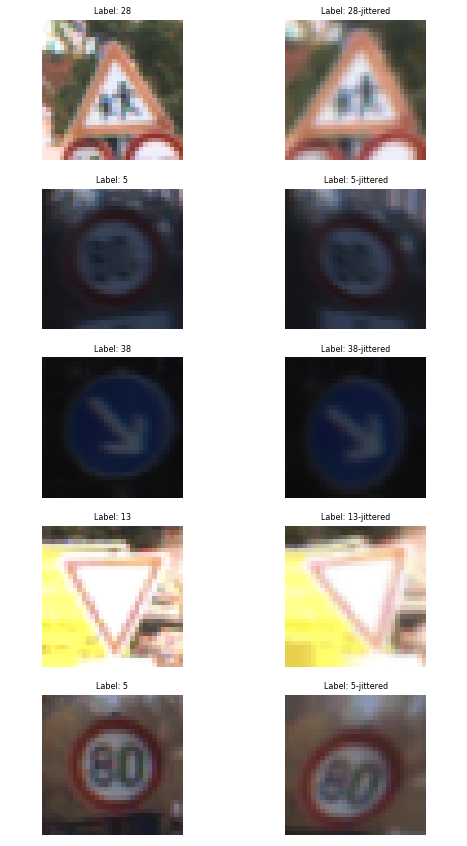

In [78]:
imgs = []
labels = []
for i in range(5):
    idx = np.random.randint(X_train.shape[0])
    img = X_train[idx]        
    jittered_img = jitterImg(img)
    
    imgs += [img, jittered_img]
    label = y_train[idx]
    labels += [label, '{}-jittered'.format(label)]

gridView(imgs, labels, ncols=2)

To solve the skewness in images' distribution, we will create 3k images per labels by randomly jittered input images

In [84]:
def build_3k_aug(images, labels):
    jittered_imgs   = []
    jittered_labels = []
    
    labels_maps = labelToIndices(labels)
    
    for i in range(43):
        idx_labeli = labels_maps[i]
        num_labeli = len(idx_labeli)
        
        for j in range(3000):
            jittered_labels += [i]
            
            if j < num_labeli: # use original image
                jittered_imgs += [images[idx_labeli[j]]]                
            else: # add augmented image
                idx = np.random.randint(num_labeli)
                jittered_imgs += [jitter_img(images[idx_labeli[idx]])]
    
    jittered_imgs   = np.array(jittered_imgs, dtype=np.float32)
    jittered_labels = np.array(jittered_labels, dtype = np.int64)    
    
    return jittered_imgs, jittered_labels

Since building extended dataset takes long time, we save it downs in pickle format

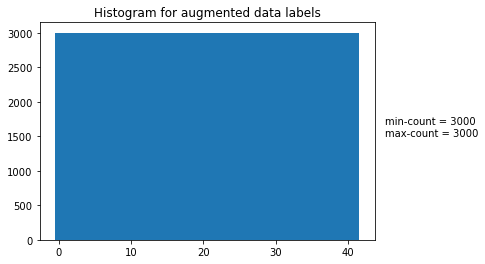

In [85]:
import os

if os.path.isfile('./datas/train_3k.p'):
    with open('./datas/train_3k.p', 'rb') as f:
        train_3k = pickle.load(f)
    X_train_3k, y_train_3k = train_extended['features'], train_extended['labels']
else:
    X_train_3k, y_train_3k = build_3k_aug(X_train, y_train)    
    
    train_extended = {'features' : X_train_3k,
                      'labels'   : y_train_3k}

    with open('./datas/train_3k.p', 'wb') as f:
        pickle.dump(train_extended, f)
        
histogram(y_train_3k, 'Histogram for augmented data labels')

#### RBG to YUV
We mimic the preprocessing as described in the [baseline model](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), first we convert RGB to YUV

In [12]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import cv2

def rgb2yuv(images):
    '''
    convert RGB image to YUV
    
    Args: 
        images (numpy.array): either 3 or 4 dims where 
            3 dims means single image, 4 dims means a mini-batch of images
    Returns:
        yuv_images: with same shape as inputs
    '''        
    if images.ndim == 4:
        yuv_images = images * 0.0
        for i in range(images.shape[0]):
            yuv_images[i] = cv2.cvtColor(images[i], cv2.COLOR_RGB2YUV)
        return images
    else:
        return cv2.cvtColor(images, cv2.COLOR_RGB2YUV)

(129000, 32, 32, 3)


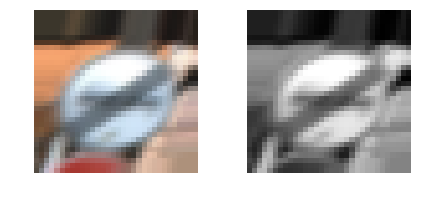

In [121]:
# try grayscale image (Y-channel)    
print(X_train_3k.shape)
idx = np.random.randint(X_train_3k.shape[0])    
img = X_train_3k[idx]
img_yuv = rgb2yuv(img) 
fig, axes = plt.subplots(figsize= [7,3], nrows=1, ncols=2, sharey=True, sharex=True)
imgs = [img, img_yuv[:,:,0]]
cmaps = [None, 'gray']
for i in range(2):
    axes[i].axis('off')
    axes[i].imshow(imgs[i], cmap = cmaps[i])

Now we are ready to pre-process input data using following pipeline
* images are converted to YUV images
* YUV images are scaled to range [0.0, 1.0] then minus 0.5 to make it contains both positive/negative inputs

In [146]:
class ImgPreprocess(object):
    def __init__(self, training_images):
        # we need to compute mean & std
        self._mean  = np.mean(training_images,        axis=0, keepdims=True)
        self._stdev = np.sqrt(np.var(training_images, axis=0, keepdims=True))
    
    def transform(self, images):
        trans_img = (images - self._mean) / self._stdev
        
        return trans_img        

# create pre-processing object    
img_pre   = ImgPreprocess(X_train)
img3k_pre = ImgPreprocess(X_train_3k)

In [147]:
# get pre-processing dataset
X_train_pre = img_pre.transform(X_train)
X_valid_pre = img_pre.transform(X_valid)
X_test_pre  = img_pre.transform(X_test)

# since mean & stddev for 3k data is different we have to preprocess X_valid & X_test second time
X_train_3k_pre = img3k_pre.transform(X_train_3k)
X_valid_3k_pre = img3k_pre.transform(X_valid)
X_test_3k_pre  = img3k_pre.transform(X_test)

### Model Architecture
We will use the same architecture as the baseline model
* the images are converted to YUV where each image is 3@32x32 (we use this notation D@WxH to describe shape of tensor)
* the model has following settings
    * `state1`: number of filters connected to Y-channels (default = 108)        
    * `state2`: number of filters in second conv-layer (default = 108)
    * `num_units`: number of hidden units in fully-connected layer for the classifier (default = 300)    
    * `use_batchnorm`: flag to decide whether to use batch-normalization or not (see [ref](https://arxiv.org/pdf/1502.03167.pdf)). If `use_batchnorm=True` then we will apply batch-norm *after each max-pool layer*

* **first state**:
    * the grayscale Y (1@32x32) input channel is applied conv with kernel-size 5x5 with number of filters = `state1` (we only use grayscale image as suggested in the baseline model and above visualization)    
    * we use ReLU-activation and 2x2 max-pool to create an ouput `state1`@16x16 (named it *conv1*) 
    
* **second state**:
    * output from the **first state** is applied conv with kernel-size 5x5 with number of filters = `state2`
    * then we use ReLU-activation and 2x2 max-pool to create an output `state2`@8x8 (named it *conv2*)
    
* **multi-scale (MS)**  features:
    * we sub-sample *conv1* by using 2x2 max-pool, then flatten it
    * we flatten *conv2*
    * we concatenate the two above to create multi-scale features
    
* **classifier**:
    * we use 2-layer (fully connected) with input is the above **(MS)** features 
    * we use number of hidden units = `num_units`
    * the output layer is softmax with cross-entropy loss

[model01]: ./assets/model01.png "Model architcture 01"

The following diagram illustrate the model's architecture for model-setting 
<center>
`state1_Y=100, state1_UV=8, state2=200, num_units=100`
</center>

![alt text][model01]

We define some helper functions to facilitate the task of building a model with Tensorflow

In [140]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers.python.layers import utils as tf_utils

def conv2d(graph, inputs, scope_name, out_channels, 
           kernel_size = 5, stride = 1):
    # we use xavier initializer
    xavier_init = tf.contrib.layers.xavier_initializer()

    in_channels = inputs.shape[-1]
    with tf.variable_scope(scope_name):
        W = tf.get_variable('weights', 
                            shape = [kernel_size, kernel_size, in_channels, out_channels],
                            initializer = xavier_init)
        b = tf.get_variable('biases',
                            shape = [out_channels],
                            initializer = tf.zeros_initializer())

        conv = tf.nn.conv2d(inputs, W, strides = [1, stride, stride, 1], padding='SAME') + b

        # add summary to inspect
        tf.summary.histogram('{}_{}'.format(scope_name, 'weights'), W)

        return tf.nn.relu(conv)

def maxpool(graph, inputs, kernel_size=2):
    return tf.nn.max_pool(inputs, 
                          ksize = [1, kernel_size, kernel_size, 1], 
                          strides = [1, kernel_size, kernel_size, 1], 
                          padding = 'SAME')

def batch_norm(graph, inputs, scope_name, is_training, decay = 0.9, eps = 1e-6):
    return tf.contrib.layers.batch_norm(inputs, 
                                        decay = decay,
                                        epsilon = eps,
                                        updates_collections = None, 
                                        is_training=is_training)
#         shape = inputs.get_shape()[1:]

#         beta = tf.get_variable('beta', shape=shape, initializer=tf.zeros_initializer())
#         gamma = tf.get_variable('gamma', shape=shape, initializer=tf.ones_initializer())

#         # define running mean/variance
#         running_mean = tf.get_variable('running_mean', shape=shape, 
#                                        initializer=tf.zeros_initializer(), trainable=False)
#         running_var = tf.get_variable('running_var', shape=shape, 
#                                        initializer=tf.ones_initializer(),  trainable=False)
        
        # since is_training is a Tensor, we need to check if it is not None => training
#         if tf_utils.constant_value(is_training) is not None:
#             batch_mean, batch_var = tf.nn.moments(inputs, [0])
#             update_mean = tf.assign(running_mean, running_mean * decay + batch_mean*(1.0 - decay))
#             update_var = tf.assign(running_var, running_var * decay + batch_var*(1.0 - decay))
#             with tf.control_dependencies([update_mean, update_var]):
#                 return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, gamma, eps)

#         else:
#             return tf.nn.batch_normalization(inputs, running_mean, running_var, beta, gamma, eps)

def fully_connected(graph, inputs, scope_name, out_channels, activation = tf.nn.relu):
    # we use xavier initializer
    xavier_init = tf.contrib.layers.xavier_initializer()

    in_channels = inputs.shape[-1]
    with tf.variable_scope(scope_name):
        W = tf.get_variable('weights', 
                            shape = [in_channels, out_channels],
                            initializer = xavier_init)
        b = tf.get_variable('biases',
                            shape = [out_channels],
                            initializer = tf.zeros_initializer())
        fc = tf.matmul(inputs, W) + b

        tf.summary.histogram('{}_{}'.format(scope_name, 'weights'), W)

        if activation is not None:
            return activation(fc)
        else:
            return fc            

Now we can define a helper function to build our model

In [41]:
DEFAULT_SETTING = {'stage1' : 108, 'stage2' : 108, 'num_units' : 200, 'keep_prob' : 1.0}

def build_model(model_settings = DEFAULT_SETTING):
    # creat a graph
    graph = tf.Graph()
    
    # create placeholder for inputs, labels
    with graph.as_default():
        inputs         = tf.placeholder(tf.float32, [None, 32, 32, 3], name='inputs')
        labels         = tf.placeholder(tf.int32, [None], name='labels')        
        labels_one_hot = tf.one_hot(labels, depth=n_classes)
        
        # drop-out & batch-norm
        keep_prob   = tf.placeholder(tf.float32, name='keep_prob')        
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        # flag to turn on/off batch-norm
        use_batchnorm = model_settings.get('use_batchnorm', False) 

        # stage 1
        # inputs_Y = tf.expand_dims(inputs[:, :, :, 0], 3)
        conv1  = conv2d(graph, inputs, 'stage1',  model_settings['stage1'])
                
        if use_batchnorm:
            conv1 = batch_norm(graph, conv1, 'stage1', is_training)
            
        max_pool1 = maxpool(graph, conv1)

        # stage 2
        conv2 = conv2d(graph, max_pool1, 'stage2', model_settings['stage2'])
        
        if use_batchnorm:
            conv2 = batch_norm(graph, conv2, 'stage2', is_training)
            
        max_pool2 = maxpool(graph, conv2)
        
        # multi-scale         
        ms_1 = tf.contrib.layers.flatten(maxpool(graph, max_pool1, kernel_size=4))
        ms_2 = tf.contrib.layers.flatten(max_pool2)
        ms = tf.concat([ms_1, ms_2], axis=1)

        # fully-connected
        fc1 = fully_connected(graph, ms,  'fc1', out_channels = model_settings['num_units'])
        
        # apply drop-out
        fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)
        
        out_logits = fully_connected(graph, fc1, 'fc2', out_channels = n_classes, activation = None)

        # compute loss
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_one_hot, 
                                                                      logits = out_logits))
        
        tf.summary.scalar('loss', loss)
        
        # compute accuracy
        pred = tf.argmax(out_logits, axis=1)
        correct_pred = tf.cast(tf.equal(pred, tf.argmax(labels_one_hot, axis=1)), tf.float32)
        
        num_corr_pred = tf.reduce_sum(correct_pred)
        accuracy = tf.reduce_mean(correct_pred)
        
        # merged summary
        merged = tf.summary.merge_all()

        # ensemble model using collections.namedtuple
        export_nodes = ['graph', 'inputs', 'labels', 'keep_prob', 'is_training', 'loss', 
                        'out_logits', 'pred', 'num_corr_pred', 'accuracy', 'merged']
        Model = collections.namedtuple('Model', export_nodes)
        local_dict = locals()
        model = Model(*[local_dict[each] for each in export_nodes])
    
    return model

### First trial
We start by trying a model described in the baseline model's paper

|               | model0  |
|---------------|---------|
| stage1        |  108    |
| stage2        |  108    |
| num_units     |  100    |
| use_batchnorm |  False  |

For this model, we don't use any regularization technique. In the following training section, you will see that this model can overfit the original dataset easily and can't perform well on validation & test set.

In [ ]:
model_0 = build_model(DEFAULT_SETTING)

### Experiment settings
So we will experiment the following model-settings (adding some regularization + new technique)

|               | model0_do | model0_do_bn  |
|---------------|-----------|---------------|
| stage1        |  108      |   108         |
| stage2        |  108      |   108         |
| num_units     |  100      |   100         |
| use_batchnorm |  False    |   True        |
| keep_prob     |  0.5      |   0.5         |


In [150]:
model_settings = []
models = []

stage1 = [108]
stage2 = [108]
bns    = [True]
for i in range(1):    
    model_settings.append({'stage1'        : stage1[i],
                           'stage2'        : stage2[i],
                           'num_units'     : 200,
                           'use_batchnorm' : True
                          })
        
for setting in model_settings:
    models.append(build_model(setting))    

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

We define some helper functions

In [129]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

def get_batch_idx(N, batch_size):
    idx = np.arange(N)
    np.random.shuffle(idx)
    num_batches = N // batch_size
    for i in range(num_batches):
        yield idx[i*batch_size : (i+1) * batch_size]

def get_feed_dict(model, inputs, labels = None, keep_prob = 1.0, is_training = False):
    feed_dict = {model.inputs : inputs, 
                 model.keep_prob : keep_prob,
                 model.is_training : is_training}
    
    if labels is not None:
        feed_dict[model.labels] = labels
    
    return feed_dict

def get_accuracy(model, sess, inputs, labels, batch_size, num_samples = None):
    idx = np.arange(inputs.shape[0])
    if num_samples is not None:
        idx = np.random.randint(inputs.shape[0], size = min(num_samples, inputs.shape[0]))
    
    i = 0
    num_correct_pred = 0
    while i < idx.shape[0]:
        i_end = min(i + batch_size, idx.shape[0])
        num_correct_pred += sess.run(model.num_corr_pred, get_feed_dict(model, 
                                                                        inputs[idx[i:i_end]],
                                                                        labels[idx[i:i_end]]))
        i += batch_size
    
    return num_correct_pred / idx.shape[0]

def get_prediction(model, sess, inputs, batch_size):
    retval = []
    N = inputs.shape[0]
    i = 0
    while i < N:
        i_end = min(i + batch_size, N)
        pred = sess.run(model.pred, get_feed_dict(model, inputs[i:i_end]))
        i += batch_size
        retval += list(pred)
    return np.array(retval)

Let's implement the training-function, we will use AdamOptimizer since it works well most of the case. The below function runs the training and pickle some debug information to a file then return its filename.

In [155]:
def run_train(model, train_inputs, train_labels, val_inputs, val_labels, test_inputs, test_labels,
              epochs, batch_size, learning_rate = 1e-3, keep_prob = 0.5, eval_every = 50, debug = True,
              log_dir = './logs', checkpoints_dir = './checkpoints', checkpoints_file = 'model.ckpt'):
    
    if not os.path.isdir(log_dir):
        os.makedirs(log_dir)
        
    if not os.path.isdir(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    N = train_inputs.shape[0]
    
    with model.graph.as_default():
        # create optimizer
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(model.loss)
        
        # create saver
        saver = tf.train.Saver(max_to_keep=50)
        
    steps      = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0.85
    best_val_cf  = os.path.join(checkpoints_dir, 'best_' + checkpoints_file)
    # to speed-up
    accuracy_batchsize = 1024
    
    with tf.Session(graph = model.graph) as sess:
        # run init
        sess.run(tf.global_variables_initializer())
        
        # create log for training/testing
        train_logger = tf.summary.FileWriter(os.path.join(log_dir, 'train'), sess.graph)
        val_logger  = tf.summary.FileWriter(os.path.join(log_dir, 'val'), sess.graph)

        # train-loop
        step = 0
        train_start = time.time()
        for e in range(epochs):
            # mini-batch gradient descent
            for idx in get_batch_idx(N, batch_size):
                inputs = train_inputs[idx]
                labels = train_labels[idx]
                start = time.time()
                cost, _, summary = sess.run([model.loss, train_opt, model.merged], 
                                            feed_dict = get_feed_dict(model, inputs, labels, 
                                                                      keep_prob = keep_prob,
                                                                      is_training = True))
                
                end = time.time()
                
                if debug:
                    sys.stdout.write( '\rEpoch({}/{}) '.format(e+1, epochs)
                                     +'Iteration {:>5d} Loss {:.4f} '.format(step+1, cost)
                                     +'Running {:.4f} sec/batch'.format(end - start) )

                if (step == 0 or (step+1) % eval_every == 0):
                    # valuate train-accuracy on a sub-samples of training set
                    train_acc = get_accuracy(model, sess, 
                                             train_inputs, train_labels, accuracy_batchsize)
                    
                    val_acc = get_accuracy(model, sess, 
                                           val_inputs, val_labels, accuracy_batchsize)
                    
                    if debug:
                        print('\nEpoch({}/{})'.format(e+1, epochs),
                              'Iteration {:>5d} train v.s validation accuracy'.format(step+1),
                              '{:5.2f}% v.s {:5.2f}%\n'.format(100.0 * train_acc, 100.0 * val_acc))
                    
                    # log it out
                    train_logger.add_summary(summary, step + 1)
                    
                    # summary validation set
                    summary = sess.run(model.merged, 
                                       feed_dict = get_feed_dict(model, val_inputs, val_labels))
                    
                    val_logger.add_summary(summary, step + 1)
                
                    # store train & val accuracy
                    train_accs.append(train_acc)
                    val_accs.append(val_acc)
                    steps.append(step+1)
                    
                    # if best val: save down checkpoint
                    if val_acc > best_val_acc:
                        saver.save(sess, best_val_cf)
                        best_val_acc = val_acc
                    
                step += 1
        
        train_end = time.time()
    
        # training-done, we measure accuracy on train,validation & test-set
        # for train & validation we can run in one-batch (since we have enough memory for this simple model)
        train_acc = get_accuracy(model, sess, train_inputs, train_labels, accuracy_batchsize)
        val_acc = get_accuracy(model, sess, val_inputs, val_labels, accuracy_batchsize)        
        test_acc = get_accuracy(model, sess,test_inputs, test_labels, accuracy_batchsize)
        
        # get prediction on validation-set
        val_pred = get_prediction(model, sess, val_inputs, batch_size)
        val_err = [(i, v, val_pred[i]) for i,v in enumerate(val_labels) if v != val_pred[i]]
        
        # store last accuracy
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        steps.append(step+1)
        
        print ('\nAfter training, we obtain',
               '\n\ttrain-accuracy      {:5.2f}%'.format(100.0*train_acc),
               '\n\tvalidation-accuracy {:5.2f}%'.format(100.0*val_acc),
               '\n\ttest-accuracy       {:5.2f}%'.format(100.0*test_acc),
               '\nTotal training time {:.4f}'.format(train_end - train_start))
        
        # saver
        checkpoint_file = os.path.join(checkpoints_dir, checkpoints_file)
        saver.save(sess, checkpoint_file)
        print('checkpoint is saved to\n\t{}'.format(checkpoint_file))
        
        # save debug file (for later)
        debug_content = {'train-accuracy' : train_acc,
                         'validation-accuracy' : val_acc,
                         'validation-errors' : val_err,
                         'test-accuracy' : test_acc,
                         'run-time' : (train_end - train_start),
                         'hyperparameter' : {'epochs' : epochs,
                                             'batch_size' : batch_size,
                                             'learning_rate' : learning_rate,
                                             'keep_prob' : keep_prob},
                         'accuracy-curve' : {'x' : steps,
                                             'y' : [('training', train_accs),
                                                    ('validation', val_accs)]}}
        
        debug_file = os.path.join(log_dir, 'debug.p')
        with open(debug_file, 'wb') as f:
            pickle.dump(debug_content, f)
    
    return debug_file, best_val_cf

Helper functions to visualize debug-file

In [156]:
import matplotlib
from matplotlib.ticker import FuncFormatter
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

def visualize_debug(debug_file):
    with open(debug_file, 'rb') as f:
        debug_content = pickle.load(f)
    
    params = debug_content['hyperparameter']
    title = 'Train v.s Validation accuracy\nepochs={},batch-size={},lr={}'.format(params['epochs'],
                                                                                  params['batch_size'],
                                                                                  params['learning_rate'])
    
    curve_data = debug_content['accuracy-curve']
    # Set the formatter
    percent_formatter = FuncFormatter(to_percent)    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.yaxis.set_major_formatter(percent_formatter)
    ax.set_ylim([0.6,1.0])
    
    for label, data in curve_data['y']:
        ax.plot(curve_data['x'], data, label = label)
    
    ax.plot([curve_data['x'][0],curve_data['x'][-1]], [0.93, 0.93], '--', label = '93%', )
    
    ax.legend(loc = 4)
    ax.set_title(title)
    

In [43]:
# TURN THIS FLAG ON IF YOU WANT TO VIEW TRAINING LOG
DEBUG = True    

#### Training model0

For this model, we set keep_prob=1.0 (no regularization)

In [157]:
# hyperparamters
epochs = 15
batch_size = 32
learning_rate = 5e-4
eval_every = 100
keep_prob = 1.0

debug_file_m0, m0_cf = run_train(model_0, X_train_pre, y_train, X_valid_pre, y_valid, X_test_pre, y_test,
                          epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, 
                          keep_prob = keep_prob, eval_every = eval_every, debug = DEBUG, 
                          log_dir = './logs/m2/lr={},kb={},epochs={}'.format(learning_rate, keep_prob, epochs),
                          checkpoints_file = 'm0_small_data.ckpt')

Epoch(1/15) Iteration     1 Loss 3.7912 Running 0.1231 sec/batch
Epoch(1/15) Iteration     1 train v.s validation accuracy  5.71% v.s  5.15%

Epoch(1/15) Iteration   100 Loss 2.4505 Running 0.0957 sec/batch
Epoch(1/15) Iteration   100 train v.s validation accuracy 30.10% v.s 23.95%

Epoch(1/15) Iteration   200 Loss 1.3057 Running 0.0763 sec/batch
Epoch(1/15) Iteration   200 train v.s validation accuracy 62.48% v.s 52.56%

Epoch(1/15) Iteration   300 Loss 0.8392 Running 0.0811 sec/batch
Epoch(1/15) Iteration   300 train v.s validation accuracy 74.63% v.s 66.30%

Epoch(1/15) Iteration   400 Loss 0.7770 Running 0.0851 sec/batch
Epoch(1/15) Iteration   400 train v.s validation accuracy 79.99% v.s 70.73%

Epoch(1/15) Iteration   500 Loss 0.7840 Running 0.0758 sec/batch
Epoch(1/15) Iteration   500 train v.s validation accuracy 87.93% v.s 78.03%

Epoch(1/15) Iteration   600 Loss 0.2020 Running 0.0745 sec/batch
Epoch(1/15) Iteration   600 train v.s validation accuracy 89.79% v.s 78.34%

Epoch(

Epoch(6/15) Iteration  5800 Loss 0.0277 Running 0.0775 sec/batch
Epoch(6/15) Iteration  5800 train v.s validation accuracy 99.58% v.s 89.82%

Epoch(6/15) Iteration  5900 Loss 0.0019 Running 0.0758 sec/batch
Epoch(6/15) Iteration  5900 train v.s validation accuracy 99.38% v.s 89.55%

Epoch(6/15) Iteration  6000 Loss 0.0056 Running 0.1114 sec/batch
Epoch(6/15) Iteration  6000 train v.s validation accuracy 99.66% v.s 90.61%

Epoch(6/15) Iteration  6100 Loss 0.0025 Running 0.1025 sec/batch
Epoch(6/15) Iteration  6100 train v.s validation accuracy 99.69% v.s 89.37%

Epoch(6/15) Iteration  6200 Loss 0.0141 Running 0.0804 sec/batch
Epoch(6/15) Iteration  6200 train v.s validation accuracy 98.31% v.s 88.53%

Epoch(6/15) Iteration  6300 Loss 0.0088 Running 0.0757 sec/batch
Epoch(6/15) Iteration  6300 train v.s validation accuracy 98.04% v.s 86.51%

Epoch(6/15) Iteration  6400 Loss 0.0186 Running 0.0880 sec/batch
Epoch(6/15) Iteration  6400 train v.s validation accuracy 99.33% v.s 89.21%

Epoch(

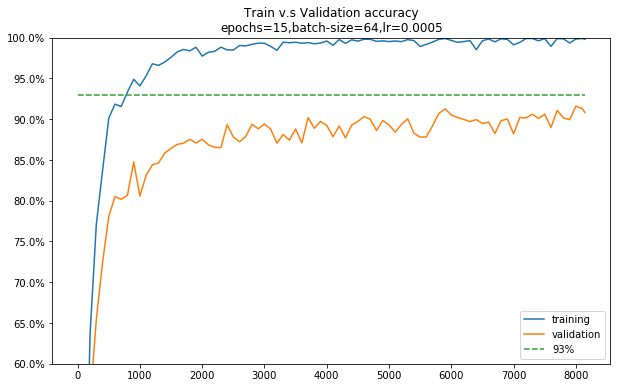

In [26]:
visualize_debug(debug_file_m0)

#### Training model0 with dropout

By setting **keep-prob=0.5** we have added a regularization on fully-connected layer of *model0*

In [139]:
# hyperparamters
epochs = 15
batch_size = 64
learning_rate = 5e-4
eval_every = 500
keep_prob = 0.5

# train
debug_file_m0_do, m0_do_cf = run_train(model_0, X_train_pre, y_train, 
                                  X_valid_pre, y_valid, X_test_pre, y_test,
                                  epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, 
                                  keep_prob = keep_prob, eval_every = eval_every, debug = DEBUG, 
                                  log_dir = './logs/m0_do/lr={},kb={},epochs={}'.format(learning_rate, keep_prob, epochs),
                                  checkpoints_file = 'm0_do_small_data.ckpt')

Epoch(1/15) Iteration     1 Loss 3.7343 Running 0.1276 sec/batch
Epoch(1/15) Iteration     1 train v.s validation accuracy  6.06% v.s  5.22%

Epoch(1/15) Iteration   500 Loss 0.8492 Running 0.0761 sec/batch
Epoch(1/15) Iteration   500 train v.s validation accuracy 89.74% v.s 79.82%

Epoch(2/15) Iteration  1000 Loss 0.3629 Running 0.0842 sec/batch
Epoch(2/15) Iteration  1000 train v.s validation accuracy 96.41% v.s 87.01%

Epoch(3/15) Iteration  1500 Loss 0.1780 Running 0.0766 sec/batch
Epoch(3/15) Iteration  1500 train v.s validation accuracy 97.79% v.s 89.25%

Epoch(4/15) Iteration  2000 Loss 0.2778 Running 0.0822 sec/batch
Epoch(4/15) Iteration  2000 train v.s validation accuracy 98.84% v.s 91.36%

Epoch(5/15) Iteration  2500 Loss 0.1376 Running 0.0750 sec/batch
Epoch(5/15) Iteration  2500 train v.s validation accuracy 99.04% v.s 91.04%

Epoch(6/15) Iteration  3000 Loss 0.0447 Running 0.0783 sec/batch
Epoch(6/15) Iteration  3000 train v.s validation accuracy 99.25% v.s 91.86%

Epoch(

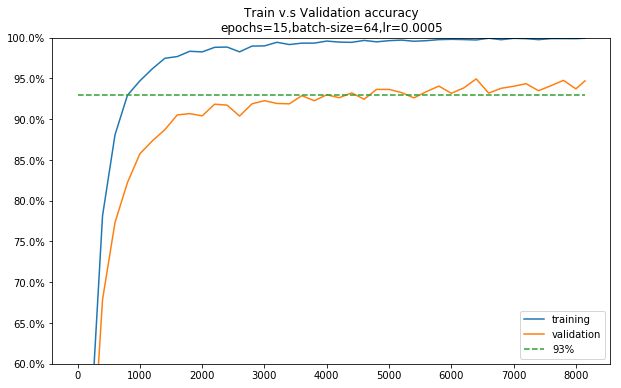

In [28]:
visualize_debug(debug_file_m0_do)

#### Train model0 with dropout + batch-norm
Let's enable batch-norm and using the same setting to train `model0` to see whether it improves the accuracy

In [149]:
# hyperparamters
epochs = 15
batch_size = 64
learning_rate = 5e-4
eval_every = 200
keep_prob = 0.5

# train
debug_file_m0_do_bn, m0_do_bn_cf = run_train(models[0], X_train_pre, y_train, 
                                        X_valid_pre, y_valid, X_test_pre, y_test,
                                        epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, 
                                        keep_prob = keep_prob, eval_every = eval_every, debug = DEBUG, 
                                        log_dir = './logs/m0_do_bn/lr={},kb={},epochs={}'.format(learning_rate, keep_prob, epochs),
                                        checkpoints_file = 'm0_do_bn_small_data.ckpt')

Epoch(1/15) Iteration     1 Loss 6.3736 Running 0.1361 sec/batch
Epoch(1/15) Iteration     1 train v.s validation accuracy  6.39% v.s  8.12%

Epoch(1/15) Iteration   200 Loss 1.6814 Running 0.0779 sec/batch
Epoch(1/15) Iteration   200 train v.s validation accuracy 62.79% v.s 52.22%

Epoch(1/15) Iteration   400 Loss 0.8935 Running 0.0762 sec/batch
Epoch(1/15) Iteration   400 train v.s validation accuracy 84.37% v.s 73.15%

Epoch(2/15) Iteration   600 Loss 0.6929 Running 0.0772 sec/batch
Epoch(2/15) Iteration   600 train v.s validation accuracy 91.55% v.s 81.13%

Epoch(2/15) Iteration   800 Loss 0.5926 Running 0.0820 sec/batch
Epoch(2/15) Iteration   800 train v.s validation accuracy 94.80% v.s 86.69%

Epoch(2/15) Iteration  1000 Loss 0.5877 Running 0.1059 sec/batch
Epoch(2/15) Iteration  1000 train v.s validation accuracy 96.70% v.s 89.43%

Epoch(3/15) Iteration  1200 Loss 0.2515 Running 0.0765 sec/batch
Epoch(3/15) Iteration  1200 train v.s validation accuracy 95.09% v.s 88.64%

Epoch(

KeyboardInterrupt: 

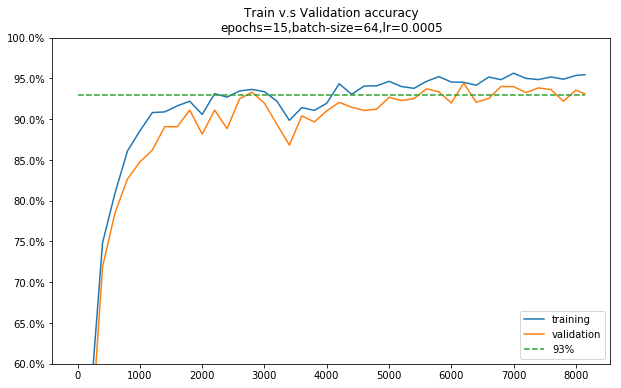

In [135]:
visualize_debug(debug_file_m0_do_bn)

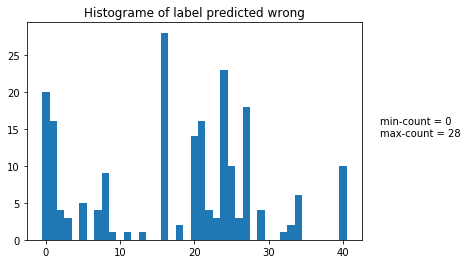

In [137]:
with open(debug_file_m0_do_bn, 'rb') as f:
    dbg_content = pickle.load(f)

val_err = dbg_content['validation-errors']
histogram([x[1] for x in val_err], 'Histograme of label predicted wrong')

#### Train with augmented data

Another way to improve our model is to train with more data. Let's try training our two models with drop-out 0.5 and batch-norm enabled

In [151]:
# hyperparamters
epochs = 20
batch_size = 32
learning_rate = 1e-4
eval_every = 2000
keep_prob = 0.5

# train
debug_file_m0_do_bn_ext, m0_do_bn_ext_cf = run_train(model_0, X_train_3k_pre, y_train_3k, 
                                    X_valid_3k_pre, y_valid, X_test_3k_pre, y_test,
                                    epochs = epochs, batch_size = batch_size, learning_rate = learning_rate, 
                                    keep_prob = keep_prob, eval_every = eval_every, debug = True, 
                                    log_dir = './logs/m1_bn_ext/lr={},kb={},epochs={}'.format(learning_rate, keep_prob, epochs),
                                    checkpoints_file = 'm1_bn_ext_data.ckpt')

Epoch(1/20) Iteration     1 Loss 3.7838 Running 0.1497 sec/batch
Epoch(1/20) Iteration     1 train v.s validation accuracy  2.29% v.s  2.74%

Epoch(1/20) Iteration  2000 Loss 1.7415 Running 0.1047 sec/batch
Epoch(1/20) Iteration  2000 train v.s validation accuracy 66.15% v.s 61.77%

Epoch(1/20) Iteration  4000 Loss 0.8873 Running 0.0872 sec/batch
Epoch(1/20) Iteration  4000 train v.s validation accuracy 81.88% v.s 76.53%

Epoch(2/20) Iteration  6000 Loss 0.8059 Running 0.0725 sec/batch
Epoch(2/20) Iteration  6000 train v.s validation accuracy 86.49% v.s 80.16%

Epoch(2/20) Iteration  8000 Loss 0.7952 Running 0.0813 sec/batch
Epoch(2/20) Iteration  8000 train v.s validation accuracy 90.25% v.s 86.30%

Epoch(3/20) Iteration 10000 Loss 0.5131 Running 0.0770 sec/batch
Epoch(3/20) Iteration 10000 train v.s validation accuracy 92.57% v.s 87.26%

Epoch(3/20) Iteration 12000 Loss 0.5080 Running 0.0901 sec/batch
Epoch(3/20) Iteration 12000 train v.s validation accuracy 93.44% v.s 87.26%

Epoch(

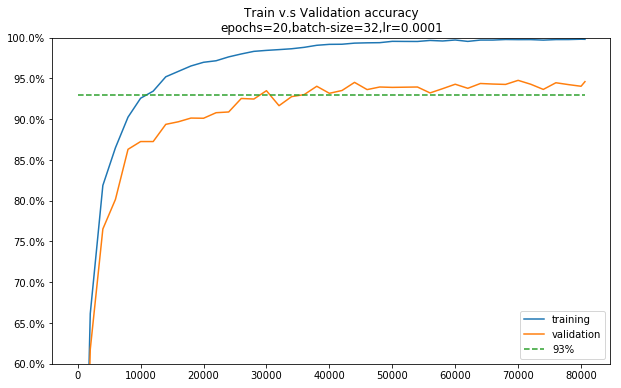

In [152]:
visualize_debug(debug_file_m0_do_bn_ext)

#### Model selection
Now let's compare performance between models

In [34]:
def compare_models(dbg_files, model_labels, title):
    # Set the formatter
    percent_formatter = FuncFormatter(to_percent)    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.yaxis.set_major_formatter(percent_formatter)
    ax.set_ylim([0.6,1.0])
    
    for dbf_file, model_label in zip(dbg_files, model_labels):
        with open(dbf_file, 'rb') as f:
            debug_content = pickle.load(f)
        
        curve_data = debug_content['accuracy-curve']
    
        for label, data in curve_data['y']:
            if label == 'validation':
                ax.plot(curve_data['x'], data, label = model_label)
                break
    
    ax.plot([curve_data['x'][0],curve_data['x'][-1]], [0.93, 0.93], '--', label = '93%', )
    ax.plot([curve_data['x'][0],curve_data['x'][-1]], [0.96, 0.96], '--', label = '96%', )
    
    ax.legend(loc = 4)
    ax.set_title(title)        

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

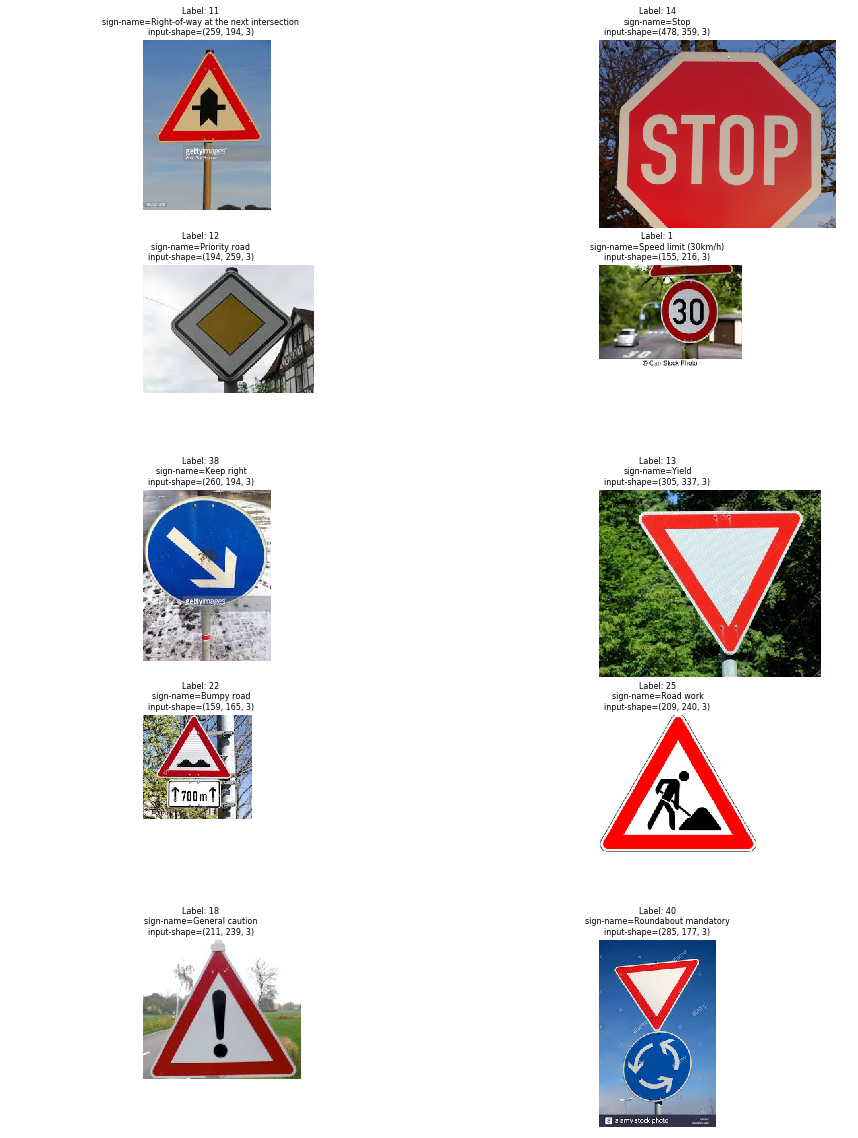

In [35]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import pandas as pd

test_dir = "./assets/test_images/"
test_data = pd.read_csv(os.path.join(test_dir, 'test_imgs_labels.csv'))
sign_name = pd.read_csv('./signnames.csv')

imgs = []
new_labels = []
img_labels = []
for fn,label in test_data[['img_file', 'label']].values:    
    img = mpimg.imread(os.path.join(test_dir, fn))    
    
    # resize it
    # img = cv2.resize(img, (32, 32))
    imgs.append(img)
    new_labels.append(label)
    img_labels.append('{}\nsign-name={}\ninput-shape={}'.format(label, sign_name['SignName'][label], img.shape))

new_labels = np.array(new_labels)
gridView(imgs, img_labels, ncols=2, figsize=(15,20))    
    

Note that our model only accept image size of (32, 32, 3), we will use tf.image.resize to convert images to correct input size

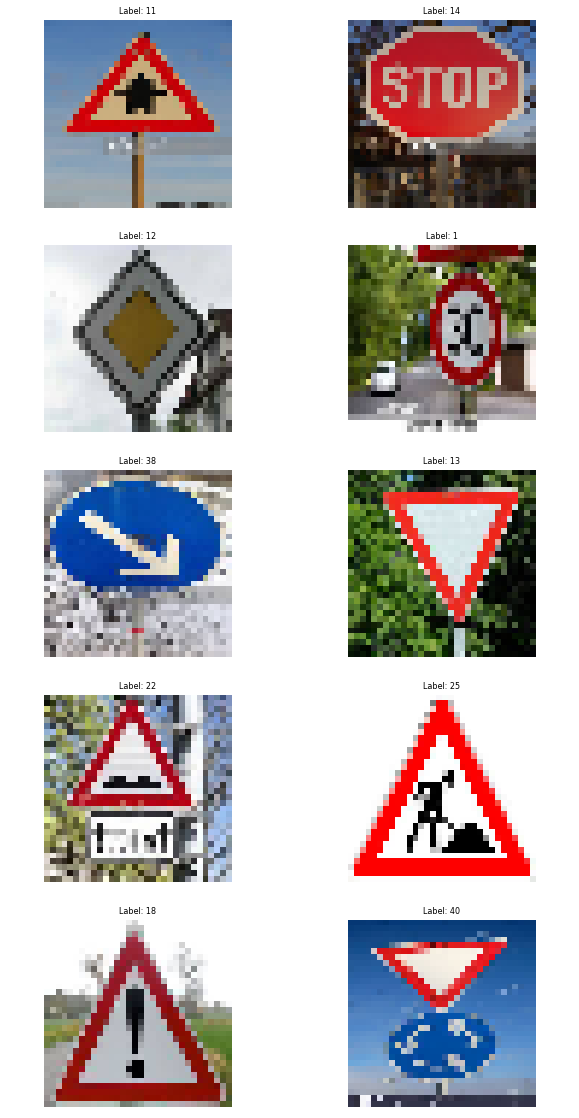

In [36]:
from skimage.transform import resize
    
imgs_scaled = [resize(img, (32,32), mode = 'edge') for img in imgs]    
gridView(imgs_scaled, new_labels, ncols=2, figsize=(10,20))  

### Predict the Sign Type for Each Image

In [37]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

def predict(imgs, model, check_point):
    with tf.Session(graph = model.graph) as sess:
        saver = tf.train.Saver()
        saver.restore(sess, check_point)
        
        preds = get_prediction(model, sess, imgs, 64)
        
        return preds

### Analyze Performance

In [39]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

new_inputs = np.array(imgs_scaled)
preds = predict(new_inputs, model_0, m0_do_bn_ext_cf)
print('true-label: {}'.format(new_labels))
print('prediction: {}'.format(preds))

accuracy = np.mean(preds == new_labels)

print('Accuracy for new images: {:.2f}%'.format(100*accuracy))

true-label: [11 14 12  1 38 13 22 25 18 40]
prediction: [30 13 12 12 38 13  9 25 18 13]
Accuracy for new images: 50.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")